# Dependências

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
import PIL

# Configurações

In [2]:
plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = (8,6)
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['font.size'] = 15

#Util

In [3]:
def load_normalize(filename, noise):

  image = PIL.Image.open(filename)
  image = image.convert("L")
  image = image.resize((28,28))

  image = np.array(image)

  # Add noise to image
  image = image + noise * np.random.normal(loc=0.0, scale=1.0, size=image.shape)
  image = np.clip(image, 0., 1.)

  image = image.astype('float32') / 255.0

  image = np.expand_dims(image, axis=-1)

  return image

# def denormalize(image):
#   return (image.reshape(28,28)*255).astype(np.uint8)

def show_image(image):

  plt.figure(figsize=(1,1))
  plt.axis('off')

  plt.imshow(image.reshape(28, 28))
  plt.gray()
  plt.show()

# Dataset

In [4]:
# Carregar o conjunto de dados MNIST como exemplo
dataset = mnist.load_data()

(X_train, _), (X_test, _) = mnist.load_data()

# Adicionar ruído às imagens de treino e teste
noise_factor = 0.5
X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)
X_test_noisy = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape)

# Garantir que os valores estejam no intervalo [0, 1]
X_train_noisy = np.clip(X_train_noisy, 0., 1.)
X_test_noisy = np.clip(X_test_noisy, 0., 1.)

# Pré-processamento dos dados
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0
X_train_noisy = X_train_noisy.astype('float32') / 255.0
X_test_noisy = X_test_noisy.astype('float32') / 255.0

X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
X_train_noisy = np.expand_dims(X_train_noisy, axis=-1)
X_test_noisy = np.expand_dims(X_test_noisy, axis=-1)

11490434/11490434 [==============================] - 0s 0us/step


# Modelo

In [5]:
# Modelo Autoencoder para filtrar ruídos
input_shape = (28, 28, 1)

# Encoder
input_layer = Input(shape=input_shape)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_layer)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)


# Criar o modelo autoencoder
autoencoder = Model(inputs=input_layer, outputs=decoded)

# Compilar o modelo
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Visualizar a arquitetura do autoencoder
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 8)           0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 8)           584   

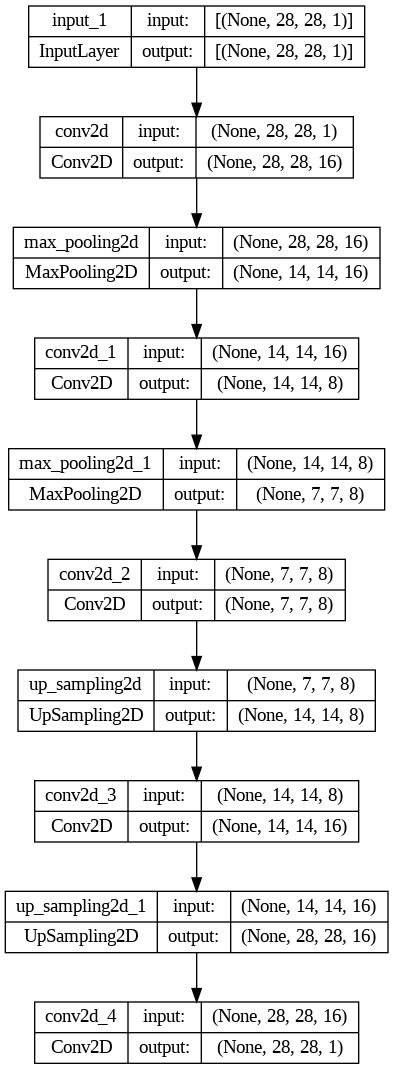

In [6]:
tf.keras.utils.plot_model(autoencoder, show_shapes=True)

# Treinamento (CPU: 10mins)

In [7]:
epochs=10
# Treinar o modelo com as imagens ruidosas como entrada e as imagens originais como saída desejada
log = autoencoder.fit(X_train_noisy, X_train, epochs=epochs, batch_size=128, shuffle=True, validation_data=(X_test_noisy, X_test))

Epoch 1/10
469/469 [==============================] - 17s 9ms/step - loss: 0.3095 - val_loss: 0.2483
Epoch 2/10
469/469 [==============================] - 3s 7ms/step - loss: 0.1782 - val_loss: 0.1406
Epoch 3/10
469/469 [==============================] - 3s 6ms/step - loss: 0.1328 - val_loss: 0.1250
Epoch 4/10
469/469 [==============================] - 3s 6ms/step - loss: 0.1221 - val_loss: 0.1173
Epoch 5/10
469/469 [==============================] - 3s 7ms/step - loss: 0.1156 - val_loss: 0.1120
Epoch 6/10
469/469 [==============================] - 4s 8ms/step - loss: 0.1113 - val_loss: 0.1084
Epoch 7/10
469/469 [==============================] - 3s 6ms/step - loss: 0.1082 - val_loss: 0.1059
Epoch 8/10
469/469 [==============================] - 3s 6ms/step - loss: 0.1058 - val_loss: 0.1037
Epoch 9/10
469/469 [==============================] - 3s 7ms/step - loss: 0.1040 - val_loss: 0.1021
Epoch 10/10
469/469 [==============================] - 4s 8ms/step - loss: 0.1026 - val_loss: 0.101

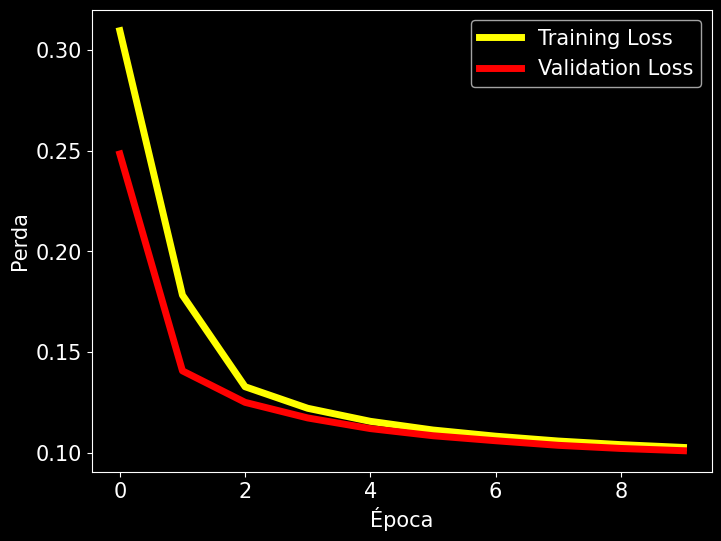

In [8]:
losses = log.history["loss"]
val_losses = log.history["val_loss"]

data_epochs = np.arange(0, epochs, 1)
plt.plot(data_epochs, losses, color="yellow", lw=5, label = 'Training Loss')
plt.plot(data_epochs, val_losses, color="red", lw=5, label = 'Validation Loss')

plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()

# Teste

313/313 [==============================] - 1s 2ms/step


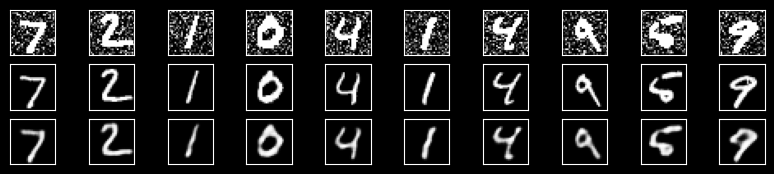

In [9]:
# Após o treinamento, você pode usar o autoencoder para filtrar ruídos das imagens
denoised_images = autoencoder.predict(X_test_noisy)

# Plotar exemplos
n = 10
plt.figure(figsize=(10, 2))

for i in range(n):
    # Imagem original com ruído
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(X_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Imagem original sem ruído
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Imagem filtrada pelo autoencoder
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(denoised_images[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

(1, 28, 28, 1)


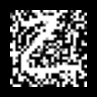

1/1 [==============================] - 0s 79ms/step
(1, 28, 28, 1)
(28, 28, 1)


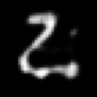

In [17]:
test_data = load_normalize("2.png", 3.0) #troque o rúido para experimentar
test_data  = np.array([test_data])

print(test_data.shape)
show_image(test_data[0])

predictions = autoencoder.predict(test_data)
print(predictions.shape)

image = predictions[0]
print(image.shape)

show_image(image)